# SPARK

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import os, pyspark

In [3]:
import pandas as pd
from kafka import KafkaProducer
from time import sleep
from json import dumps
import json

In [4]:
# folder location
path = "E:/spark"

# fetch all files
dir_list = os.listdir(path)

# prints all files
print(dir_list)

dir_list.remove('SeoulFloating.csv') # due to huge size crashing the server on local

# prints all files
print(dir_list)

['Case.csv', 'PatientInfo.csv', 'Policy.csv', 'Region.csv', 'SearchTrend.csv', 'SeoulFloating.csv', 'Time.csv', 'TimeAge.csv', 'TimeGender.csv', 'TimeProvince.csv', 'Weather.csv']
['Case.csv', 'PatientInfo.csv', 'Policy.csv', 'Region.csv', 'SearchTrend.csv', 'Time.csv', 'TimeAge.csv', 'TimeGender.csv', 'TimeProvince.csv', 'Weather.csv']


# KAFKA PRODUCER

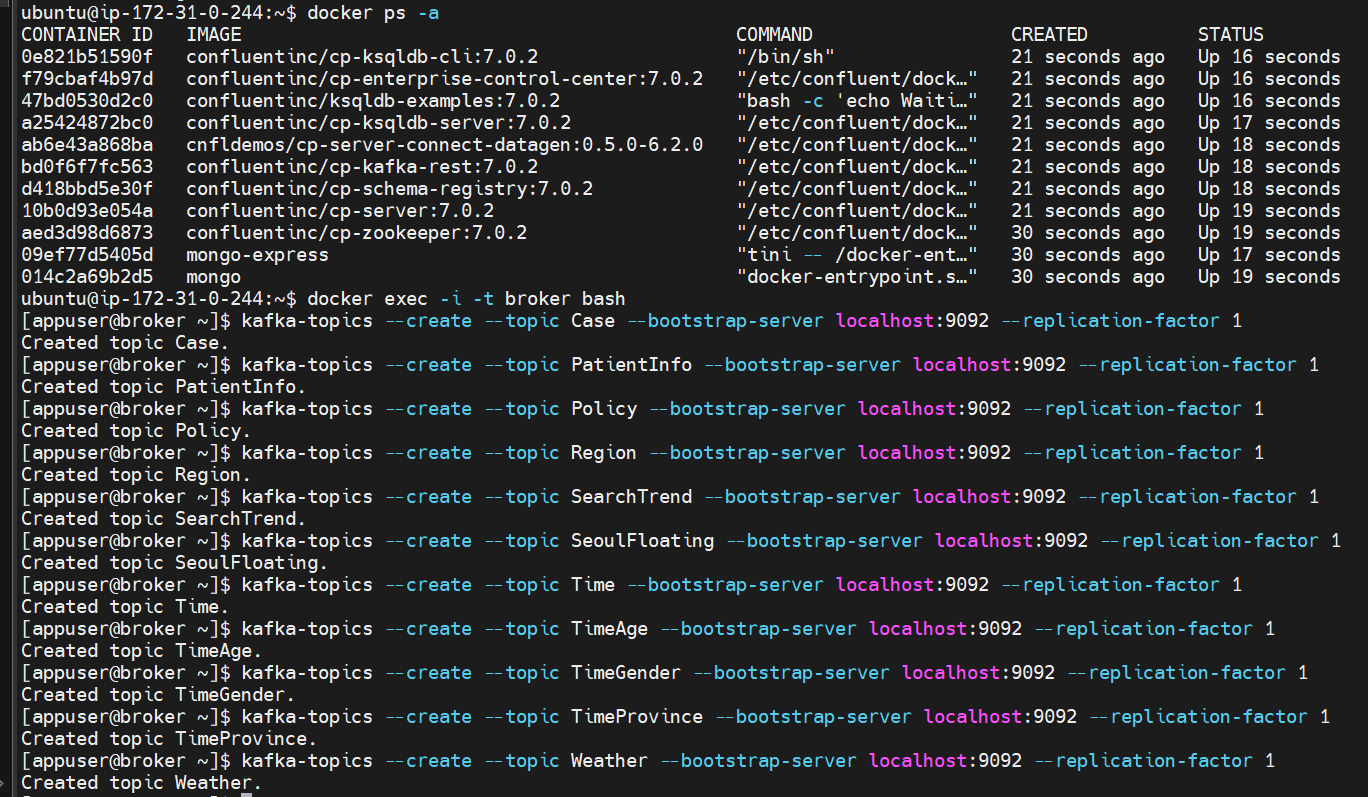

In [5]:
producer = KafkaProducer(bootstrap_servers=['localhost:9092'],
                         value_serializer=lambda x: 
                         dumps(x).encode('utf-8'))

In [6]:
# read files to dataframe and publish via producer
for f in dir_list:
    
    # create file path
    filePath = path + '/' + f
    
    # read to dataFrame
    df = pd.read_csv(filePath)
    df = df.applymap(str)
    
    # add new index common to add files
    df['myIndex'] = df.index
    
    # create dict records format
    dict_data = df.to_dict('records')
    print(dict_data[0])
    # print number of records in each file
    print('number of records in the file -->', f, '-', len(dict_data))
    print('data to be published on topic -->',f.replace('.csv',''))
    print('')
    
    # for each record in the file, publish to kafka via producer
    for d in range(len(dict_data)):   
        producer.send(f.replace('.csv',''), value=dict_data[d],key=json.dumps(dict_data[d]["myIndex"]).encode('utf-8'))

{' case_id': '1000001', 'province': 'Seoul', 'city': 'Yongsan-gu', 'group': 'True', 'infection_case': 'Itaewon Clubs', 'confirmed': '139', 'latitude': '37.538621', 'longitude': '126.992652', 'myIndex': 0}
number of records in the file --> Case.csv - 174
data to be published on topic --> Case

{'patient_id': '1000000001', 'sex': 'male', 'age': '50s', 'country': 'Korea', 'province': 'Seoul', 'city': 'Gangseo-gu', 'infection_case': 'overseas inflow', 'infected_by': 'nan', 'contact_number': '75', 'symptom_onset_date': '2020-01-22', 'confirmed_date': '2020-01-23', 'released_date': '2020-02-05', 'deceased_date': 'nan', 'state': 'released', 'myIndex': 0}
number of records in the file --> PatientInfo.csv - 5165
data to be published on topic --> PatientInfo

{'policy_id': '1', 'country': 'Korea', 'type': 'Alert', 'gov_policy': 'Infectious Disease Alert Level', 'detail': 'Level 1 (Blue)', 'start_date': '2020-01-03', 'end_date': '2020-01-19', 'myIndex': 0}
number of records in the file --> Policy

# KAFKA CONSUMER

In [7]:
# list of topics to subscribe for
topicsList = ['Case', 'Region', 'TimeProvince']

In [63]:
spark.stop()

In [64]:
table = topicsList[0]

In [65]:
# kafka & mongo db configs
spark = SparkSession.builder.appName("pyspark-kafka-mongo").\
config("spark.jars.packages","org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0,org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
config("spark.mongodb.input.uri","mongodb://localhost:27017/covidDb."+table).\
config("spark.mongodb.output.uri","mongodb://localhost:27017/covidDb."+table).\
getOrCreate()

In [75]:
sp_caseDf = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", table) \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load() \
    .select("value") \
    .selectExpr("CAST(value AS STRING) as json")

In [76]:
sp_caseDf.show(5)

+--------------------+
|                json|
+--------------------+
|{" case_id": "100...|
|{" case_id": "100...|
|{" case_id": "100...|
|{" case_id": "100...|
|{" case_id": "100...|
+--------------------+
only showing top 5 rows



In [77]:
# region schema
jsonSchema = StructType([StructField("case_id", StringType(), True), \
                         StructField("province", StringType(), True), \
                         StructField("city", StringType(), True), \
                         StructField("group", StringType(), True), \
                         StructField("infection_case", StringType(), True), \
                         StructField("confirmed", StringType(), True), \
                         StructField("latitude", StringType(), True), \
                         StructField("longitude", StringType(), True)])

In [78]:
# Parsing and selecting the right column data - Converting json read to table format
sp_caseDf = sp_caseDf.withColumn("jsonData", from_json(col("json"), jsonSchema)).select("jsonData.*")

In [79]:
sp_caseDf = sp_caseDf.drop("case_id")

In [80]:
sp_caseDf.show(5)

+--------+------------+-----+--------------------+---------+---------+----------+
|province|        city|group|      infection_case|confirmed| latitude| longitude|
+--------+------------+-----+--------------------+---------+---------+----------+
|   Seoul|  Yongsan-gu| True|       Itaewon Clubs|      139|37.538621|126.992652|
|   Seoul|   Gwanak-gu| True|             Richway|      119| 37.48208|126.901384|
|   Seoul|     Guro-gu| True| Guro-gu Call Center|       95|37.508163|126.884387|
|   Seoul|Yangcheon-gu| True|Yangcheon Table T...|       43|37.546061|126.874209|
|   Seoul|   Dobong-gu| True|     Day Care Center|       43|37.679422|127.044374|
+--------+------------+-----+--------------------+---------+---------+----------+
only showing top 5 rows



In [81]:
# write results to csv to read later for processing
sp_caseDf.write.mode("overwrite").option("header",True).format("csv").save("E:\\iNeuron\\SparkAssignment\\results_from_kafka\\"+table)

In [82]:
# write to mongo
sp_caseDf.select("province","city","group", "infection_case", "confirmed", "latitude", "longitude").write.format("mongo").mode("append").save()

# Add MongoDB Contents
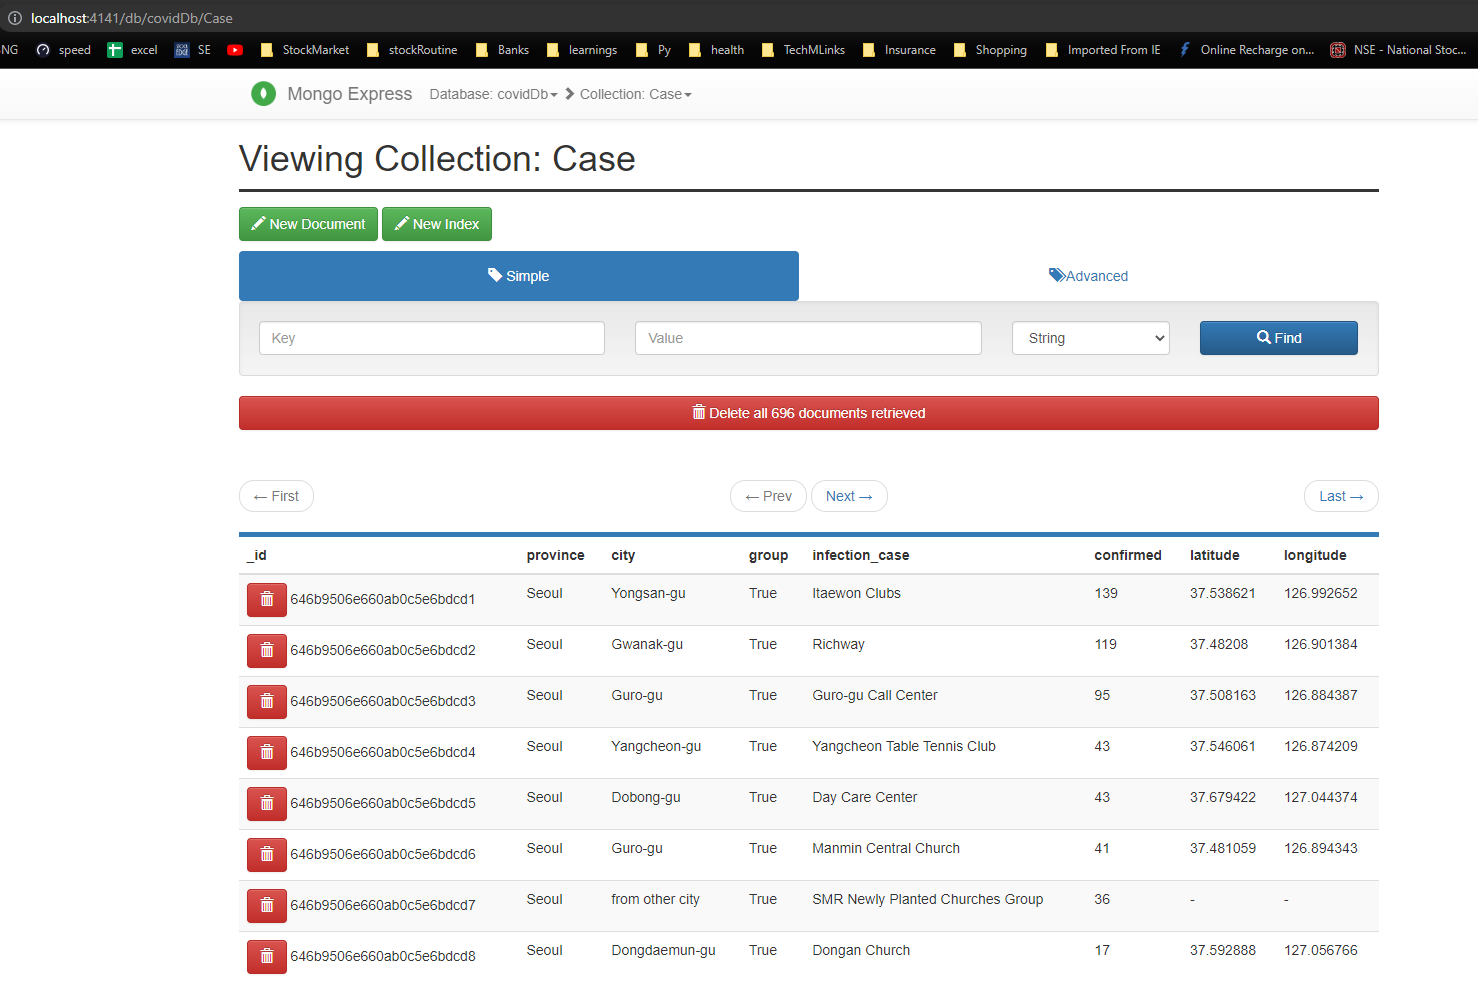

In [83]:
sp_casedf = spark.read.format("mongo").load()
sp_casedf.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- city: string (nullable = true)
 |-- confirmed: string (nullable = true)
 |-- group: string (nullable = true)
 |-- infection_case: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- province: string (nullable = true)



In [84]:
sp_casedf.show()

+--------------------+---------------+---------+-----+--------------------+---------+----------+--------+
|                 _id|           city|confirmed|group|      infection_case| latitude| longitude|province|
+--------------------+---------------+---------+-----+--------------------+---------+----------+--------+
|{646b9506e660ab0c...|     Yongsan-gu|      139| True|       Itaewon Clubs|37.538621|126.992652|   Seoul|
|{646b9506e660ab0c...|      Gwanak-gu|      119| True|             Richway| 37.48208|126.901384|   Seoul|
|{646b9506e660ab0c...|        Guro-gu|       95| True| Guro-gu Call Center|37.508163|126.884387|   Seoul|
|{646b9506e660ab0c...|   Yangcheon-gu|       43| True|Yangcheon Table T...|37.546061|126.874209|   Seoul|
|{646b9506e660ab0c...|      Dobong-gu|       43| True|     Day Care Center|37.679422|127.044374|   Seoul|
|{646b9506e660ab0c...|        Guro-gu|       41| True|Manmin Central Ch...|37.481059|126.894343|   Seoul|
|{646b9506e660ab0c...|from other city|       3

In [85]:
##EOD OF CASE

In [86]:
# region schema
jsonSchema = StructType([StructField("code", StringType(), True), \
                         StructField("province", StringType(), True), \
                         StructField("city", StringType(), True), \
                         StructField("latitude", StringType(), True), \
                         StructField("longitude", StringType(), True), \
                         StructField("elementary_school_count", StringType(), True), \
                         StructField("kindergarten_count", StringType(), True), \
                         StructField("university_count", StringType(), True), \
                         StructField("academy_ratio", StringType(), True), \
                         StructField("elderly_population_ratio", StringType(), True), \
                         StructField("elderly_alone_ratio", StringType(), True), \
                         StructField("nursing_home_count", StringType(), True)])

In [87]:
table=topicsList[1]

In [88]:
spark.stop()

In [89]:
# kafka & mongo db configs
spark = SparkSession.builder.appName("pyspark-kafka-mongo").\
config("spark.jars.packages","org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0,org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
config("spark.mongodb.input.uri","mongodb://localhost:27017/covidDb."+table).\
config("spark.mongodb.output.uri","mongodb://localhost:27017/covidDb."+table).\
getOrCreate()

In [90]:
sp_regiondf = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", table) \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load() \
    .select("value") \
    .selectExpr("CAST(value AS STRING) as json")

In [91]:
sp_regiondf.show(5)

+--------------------+
|                json|
+--------------------+
|{"code": "10000",...|
|{"code": "10010",...|
|{"code": "10020",...|
|{"code": "10030",...|
|{"code": "10040",...|
+--------------------+
only showing top 5 rows



In [92]:
# Parsing and selecting the right column data - Converting json read to table format
sp_regiondf = sp_regiondf.withColumn("jsonData", from_json(col("json"), jsonSchema)).select("jsonData.*")

In [93]:
sp_regiondf.show(5)

+-----+--------+-----------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
| code|province|       city| latitude| longitude|elementary_school_count|kindergarten_count|university_count|academy_ratio|elderly_population_ratio|elderly_alone_ratio|nursing_home_count|
+-----+--------+-----------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
|10000|   Seoul|      Seoul|37.566953|126.977977|                    607|               830|              48|         1.44|                   15.38|                5.8|             22739|
|10010|   Seoul| Gangnam-gu|37.518421|127.047222|                     33|                38|               0|         4.18|                   13.17|                4.3|              3088|
|10020|   Seoul|Gangdong-gu|37.530492|127.123837|           

In [94]:
# write results to csv to read later for processing
sp_regiondf.write.mode("overwrite").option("header",True).format("csv").save("E:\\iNeuron\\SparkAssignment\\results_from_kafka\\"+table)

In [95]:
# write to mongo
sp_regiondf.select("code","province","city", "latitude", "longitude", "elementary_school_count", "kindergarten_count", "university_count", "academy_ratio", "elderly_population_ratio", "elderly_alone_ratio", "nursing_home_count").write.format("mongo").mode("append").save()

# MongoDb Contents for Region Data
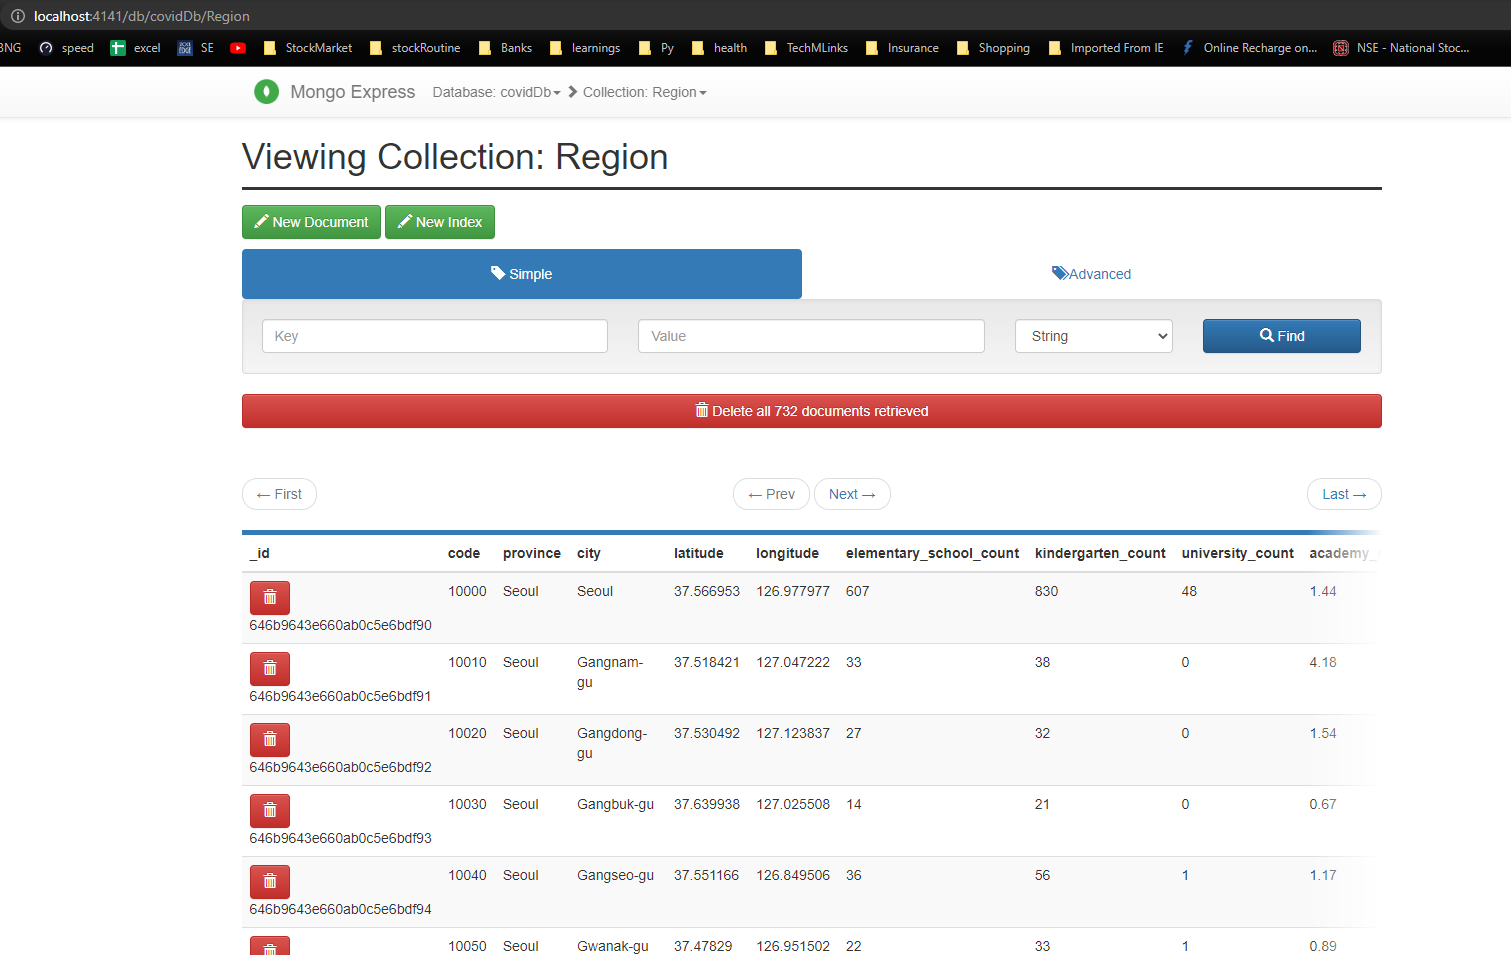

In [96]:
# read from mongo to validate the contents match
sp_regiondf = spark.read.format("mongo").load()
sp_regiondf.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- academy_ratio: string (nullable = true)
 |-- city: string (nullable = true)
 |-- code: string (nullable = true)
 |-- elderly_alone_ratio: string (nullable = true)
 |-- elderly_population_ratio: string (nullable = true)
 |-- elementary_school_count: string (nullable = true)
 |-- kindergarten_count: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- nursing_home_count: string (nullable = true)
 |-- province: string (nullable = true)
 |-- university_count: string (nullable = true)



In [97]:
sp_regiondf.show(5)

+--------------------+-------------+-----------+-----+-------------------+------------------------+-----------------------+------------------+---------+----------+------------------+--------+----------------+
|                 _id|academy_ratio|       city| code|elderly_alone_ratio|elderly_population_ratio|elementary_school_count|kindergarten_count| latitude| longitude|nursing_home_count|province|university_count|
+--------------------+-------------+-----------+-----+-------------------+------------------------+-----------------------+------------------+---------+----------+------------------+--------+----------------+
|{646b9643e660ab0c...|         1.44|      Seoul|10000|                5.8|                   15.38|                    607|               830|37.566953|126.977977|             22739|   Seoul|              48|
|{646b9643e660ab0c...|         4.18| Gangnam-gu|10010|                4.3|                   13.17|                     33|                38|37.518421|127.047222| 

In [98]:
##EOD of Region

In [99]:
# timeProvince schema
jsonSchema = StructType([StructField("date", StringType(), True), \
                         StructField("time", StringType(), True), \
                         StructField("province", StringType(), True), \
                         StructField("confirmed", StringType(), True), \
                         StructField("released", StringType(), True), \
                         StructField("deceased", StringType(), True)])

In [100]:
table=topicsList[2]

In [101]:
spark.stop()

In [102]:
# kafka & mongo db configs
spark = SparkSession.builder.appName("pyspark-kafka-mongo").\
config("spark.jars.packages","org.mongodb.spark:mongo-spark-connector_2.12:3.0.0,org.apache.spark:spark-streaming-kafka-0-10_2.12:3.4.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.4.0 pyspark-shell").\
config("spark.mongodb.input.uri","mongodb://localhost:27017/covidDb."+table).\
config("spark.mongodb.output.uri","mongodb://localhost:27017/covidDb."+table).\
getOrCreate()

In [103]:
sp_timeprovincedf = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", table) \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load() \
    .select("value") \
    .selectExpr("CAST(value AS STRING) as json")

In [104]:
sp_timeprovincedf.show(5)

+--------------------+
|                json|
+--------------------+
|{"date": "2020-01...|
|{"date": "2020-01...|
|{"date": "2020-01...|
|{"date": "2020-01...|
|{"date": "2020-01...|
+--------------------+
only showing top 5 rows



In [105]:
# Parsing and selecting the right column data - Converting json read to table format
sp_timeprovincedf = sp_timeprovincedf.withColumn("jsonData", from_json(col("json"), jsonSchema)).select("jsonData.*")

In [106]:
sp_timeprovincedf.show(5)

+----------+----+--------+---------+--------+--------+
|      date|time|province|confirmed|released|deceased|
+----------+----+--------+---------+--------+--------+
|2020-01-20|  16|   Seoul|        0|       0|       0|
|2020-01-20|  16|   Busan|        0|       0|       0|
|2020-01-20|  16|   Daegu|        0|       0|       0|
|2020-01-20|  16| Incheon|        1|       0|       0|
|2020-01-20|  16| Gwangju|        0|       0|       0|
+----------+----+--------+---------+--------+--------+
only showing top 5 rows



In [107]:
# write results to csv to read later for processing
sp_timeprovincedf.write.mode("overwrite").option("header",True).format("csv").save("E:\\iNeuron\\SparkAssignment\\results_from_kafka\\"+table)

In [108]:
# write to mongo
sp_timeprovincedf.select("date","time","province", "confirmed", "released", "deceased").write.format("mongo").mode("append").save()

# MongoDb Contents for TimeProvince Data
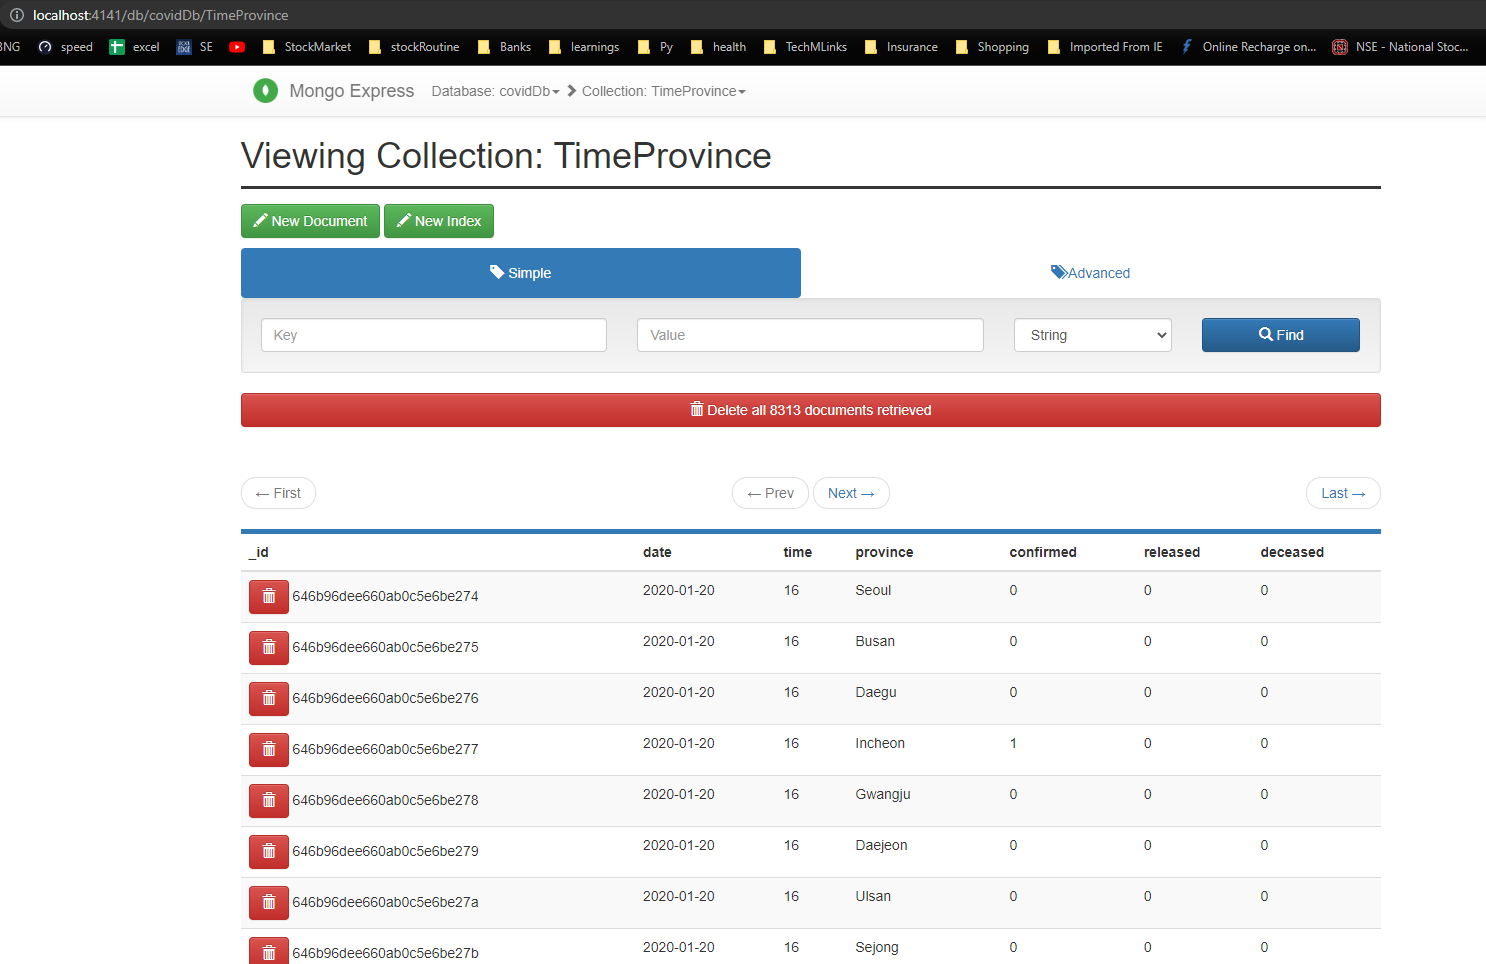

In [109]:
# read from mongo to validate the contents match
sp_timeprovincedf = spark.read.format("mongo").load()
sp_timeprovincedf.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- confirmed: string (nullable = true)
 |-- date: string (nullable = true)
 |-- deceased: string (nullable = true)
 |-- province: string (nullable = true)
 |-- released: string (nullable = true)
 |-- time: string (nullable = true)



In [110]:
sp_timeprovincedf.show(5)

+--------------------+---------+----------+--------+--------+--------+----+
|                 _id|confirmed|      date|deceased|province|released|time|
+--------------------+---------+----------+--------+--------+--------+----+
|{646b96dee660ab0c...|        0|2020-01-20|       0|   Seoul|       0|  16|
|{646b96dee660ab0c...|        0|2020-01-20|       0|   Busan|       0|  16|
|{646b96dee660ab0c...|        0|2020-01-20|       0|   Daegu|       0|  16|
|{646b96dee660ab0c...|        1|2020-01-20|       0| Incheon|       0|  16|
|{646b96dee660ab0c...|        0|2020-01-20|       0| Gwangju|       0|  16|
+--------------------+---------+----------+--------+--------+--------+----+
only showing top 5 rows



In [111]:
# EOD of TimeProvince

In [112]:
spark.stop()

# Show Spark DataFrames

In [113]:
spark = SparkSession.builder.\
master("local").appName("PySpark_MySQL").getOrCreate()

In [145]:
sp_casedf = spark.read.option("header",True).option("inferSchema",True).csv("E:\\iNeuron\\SparkAssignment\\results_from_kafka\\"+topicsList[0])

In [115]:
sp_casedf.show()

+--------+---------------+-----+--------------------+---------+---------+----------+
|province|           city|group|      infection_case|confirmed| latitude| longitude|
+--------+---------------+-----+--------------------+---------+---------+----------+
|   Seoul|     Yongsan-gu| true|       Itaewon Clubs|      139|37.538621|126.992652|
|   Seoul|      Gwanak-gu| true|             Richway|      119| 37.48208|126.901384|
|   Seoul|        Guro-gu| true| Guro-gu Call Center|       95|37.508163|126.884387|
|   Seoul|   Yangcheon-gu| true|Yangcheon Table T...|       43|37.546061|126.874209|
|   Seoul|      Dobong-gu| true|     Day Care Center|       43|37.679422|127.044374|
|   Seoul|        Guro-gu| true|Manmin Central Ch...|       41|37.481059|126.894343|
|   Seoul|from other city| true|SMR Newly Planted...|       36|        -|         -|
|   Seoul|  Dongdaemun-gu| true|       Dongan Church|       17|37.592888|127.056766|
|   Seoul|from other city| true|Coupang Logistics...|       25|  

In [116]:
sp_regiondf = spark.read.option("header",True).option("inferSchema",True).csv("E:\\iNeuron\\SparkAssignment\\results_from_kafka\\"+topicsList[1])

In [117]:
sp_regiondf.show()

+-----+--------+-------------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
| code|province|         city| latitude| longitude|elementary_school_count|kindergarten_count|university_count|academy_ratio|elderly_population_ratio|elderly_alone_ratio|nursing_home_count|
+-----+--------+-------------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
|10000|   Seoul|        Seoul|37.566953|126.977977|                    607|               830|              48|         1.44|                   15.38|                5.8|             22739|
|10010|   Seoul|   Gangnam-gu|37.518421|127.047222|                     33|                38|               0|         4.18|                   13.17|                4.3|              3088|
|10020|   Seoul|  Gangdong-gu|37.530492|127.123837

In [119]:
sp_timeprovincedf = spark.read.option("header",True).option("inferSchema",True).csv("E:\\iNeuron\\SparkAssignment\\results_from_kafka\\"+topicsList[2])

In [120]:
sp_timeprovincedf.show()

+----------+----+-----------------+---------+--------+--------+
|      date|time|         province|confirmed|released|deceased|
+----------+----+-----------------+---------+--------+--------+
|2020-01-20|  16|            Seoul|        0|       0|       0|
|2020-01-20|  16|            Busan|        0|       0|       0|
|2020-01-20|  16|            Daegu|        0|       0|       0|
|2020-01-20|  16|          Incheon|        1|       0|       0|
|2020-01-20|  16|          Gwangju|        0|       0|       0|
|2020-01-20|  16|          Daejeon|        0|       0|       0|
|2020-01-20|  16|            Ulsan|        0|       0|       0|
|2020-01-20|  16|           Sejong|        0|       0|       0|
|2020-01-20|  16|      Gyeonggi-do|        0|       0|       0|
|2020-01-20|  16|       Gangwon-do|        0|       0|       0|
|2020-01-20|  16|Chungcheongbuk-do|        0|       0|       0|
|2020-01-20|  16|Chungcheongnam-do|        0|       0|       0|
|2020-01-20|  16|     Jeollabuk-do|     

# COUNTS of Each Spark DataFrame

In [121]:
sp_casedf.count()

696

In [122]:
sp_regiondf.count()

732

In [123]:
sp_timeprovincedf.count()

8313

# Describe

In [124]:
sp_casedf.describe()

DataFrame[summary: string, province: string, city: string, infection_case: string, confirmed: string, latitude: string, longitude: string]

In [125]:
sp_regiondf.describe()

DataFrame[summary: string, code: string, province: string, city: string, latitude: string, longitude: string, elementary_school_count: string, kindergarten_count: string, university_count: string, academy_ratio: string, elderly_population_ratio: string, elderly_alone_ratio: string, nursing_home_count: string]

In [126]:
sp_timeprovincedf.describe()

DataFrame[summary: string, time: string, province: string, confirmed: string, released: string, deceased: string]

# DUPLICATES

In [127]:
sp_casedf_duplicates = sp_casedf.groupBy(sp_casedf.columns).count().filter(col("count")>1)
sp_casedf_duplicates.show()

+-----------------+---------------+-----+--------------------+---------+---------+----------+-----+
|         province|           city|group|      infection_case|confirmed| latitude| longitude|count|
+-----------------+---------------+-----+--------------------+---------+---------+----------+-----+
|            Seoul|   Yangcheon-gu| true|Yangcheon Table T...|       43|37.546061|126.874209|    4|
|          Incheon|              -|false|     overseas inflow|       68|        -|         -|    4|
| Gyeongsangnam-do|from other city| true|       Itaewon Clubs|        2|        -|         -|    4|
|            Seoul|      Jongno-gu| true|Jongno Community ...|       10| 37.57681|   127.006|    4|
|      Gyeonggi-do|     Bucheon-si| true|Coupang Logistics...|       67|37.530579|126.775254|    4|
|            Seoul|     Gangnam-gu| true|Samsung Fire & Ma...|        4|37.498279|127.030139|    4|
|          Daejeon|from other city| true|Seosan-si Laboratory|        2|        -|         -|    4|


In [128]:
sp_regiondf_duplicates = sp_regiondf.groupBy(sp_regiondf.columns).count().filter(col("count")>1)
sp_regiondf_duplicates.show()

+-----+-----------------+-------------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+-----+
| code|         province|         city| latitude| longitude|elementary_school_count|kindergarten_count|university_count|academy_ratio|elderly_population_ratio|elderly_alone_ratio|nursing_home_count|count|
+-----+-----------------+-------------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+-----+
|10000|            Seoul|        Seoul|37.566953|126.977977|                    607|               830|              48|         1.44|                   15.38|                5.8|             22739|    3|
|10100|            Seoul|    Dobong-gu|37.668952|127.047082|                     23|                26|               1|         0.95|                   17.89|                7.2| 

In [129]:
sp_timeprovincedf_duplicates = sp_timeprovincedf.groupBy(sp_timeprovincedf.columns).count().filter(col("count")>1)
sp_timeprovincedf_duplicates.show()

+----------+----+-----------------+---------+--------+--------+-----+
|      date|time|         province|confirmed|released|deceased|count|
+----------+----+-----------------+---------+--------+--------+-----+
|2020-01-23|  16|     Jeollabuk-do|        0|       0|       0|    3|
|2020-01-31|  16|Chungcheongbuk-do|        0|       0|       0|    3|
|2020-02-01|  16|          Incheon|        1|       0|       0|    3|
|2020-03-02|   0|Chungcheongnam-do|       78|       0|       0|    3|
|2020-03-15|   0|           Sejong|       39|       0|       0|    3|
|2020-03-29|   0|          Incheon|       58|      15|       0|    3|
|2020-04-07|   0| Gyeongsangbuk-do|     1317|     934|      46|    3|
|2020-05-10|   0| Gyeongsangnam-do|      117|     108|       0|    3|
|2020-05-12|   0|       Gangwon-do|       54|      41|       2|    3|
|2020-05-20|   0|          Gwangju|       30|      30|       0|    3|
|2020-05-21|   0|            Seoul|      756|     596|       4|    3|
|2020-05-30|   0|   

# LIMIT

In [130]:
sp_casedf.show(5)

+--------+------------+-----+--------------------+---------+---------+----------+
|province|        city|group|      infection_case|confirmed| latitude| longitude|
+--------+------------+-----+--------------------+---------+---------+----------+
|   Seoul|  Yongsan-gu| true|       Itaewon Clubs|      139|37.538621|126.992652|
|   Seoul|   Gwanak-gu| true|             Richway|      119| 37.48208|126.901384|
|   Seoul|     Guro-gu| true| Guro-gu Call Center|       95|37.508163|126.884387|
|   Seoul|Yangcheon-gu| true|Yangcheon Table T...|       43|37.546061|126.874209|
|   Seoul|   Dobong-gu| true|     Day Care Center|       43|37.679422|127.044374|
+--------+------------+-----+--------------------+---------+---------+----------+
only showing top 5 rows



In [131]:
sp_regiondf.show(5)

+-----+--------+-----------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
| code|province|       city| latitude| longitude|elementary_school_count|kindergarten_count|university_count|academy_ratio|elderly_population_ratio|elderly_alone_ratio|nursing_home_count|
+-----+--------+-----------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
|10000|   Seoul|      Seoul|37.566953|126.977977|                    607|               830|              48|         1.44|                   15.38|                5.8|             22739|
|10010|   Seoul| Gangnam-gu|37.518421|127.047222|                     33|                38|               0|         4.18|                   13.17|                4.3|              3088|
|10020|   Seoul|Gangdong-gu|37.530492|127.123837|           

In [132]:
sp_timeprovincedf.show(5)

+----------+----+--------+---------+--------+--------+
|      date|time|province|confirmed|released|deceased|
+----------+----+--------+---------+--------+--------+
|2020-01-20|  16|   Seoul|        0|       0|       0|
|2020-01-20|  16|   Busan|        0|       0|       0|
|2020-01-20|  16|   Daegu|        0|       0|       0|
|2020-01-20|  16| Incheon|        1|       0|       0|
|2020-01-20|  16| Gwangju|        0|       0|       0|
+----------+----+--------+---------+--------+--------+
only showing top 5 rows



# RENAME COLUMN NAME

In [133]:
sp_regiondf_updated = sp_regiondf.withColumnRenamed("nursing_home_count","nursing_count")
sp_regiondf_updated.show(1)

+-----+--------+-----+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+-------------+
| code|province| city| latitude| longitude|elementary_school_count|kindergarten_count|university_count|academy_ratio|elderly_population_ratio|elderly_alone_ratio|nursing_count|
+-----+--------+-----+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+-------------+
|10000|   Seoul|Seoul|37.566953|126.977977|                    607|               830|              48|         1.44|                   15.38|                5.8|        22739|
+-----+--------+-----+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+-------------+
only showing top 1 row



# Subset of Columns

In [146]:
# print column names
for col in sp_casedf.columns:
    print(col)

province
city
group
infection_case
confirmed
latitude
longitude


In [147]:
import re
from pyspark.sql.functions import col

# remove spaces from column names
newcols = [col(column).alias(re.sub('\s*', '', column)) for column in df.columns]

# rename columns
sp_casedf.select("province","city").show()

+--------+---------------+
|province|           city|
+--------+---------------+
|   Seoul|     Yongsan-gu|
|   Seoul|      Gwanak-gu|
|   Seoul|        Guro-gu|
|   Seoul|   Yangcheon-gu|
|   Seoul|      Dobong-gu|
|   Seoul|        Guro-gu|
|   Seoul|from other city|
|   Seoul|  Dongdaemun-gu|
|   Seoul|from other city|
|   Seoul|      Gwanak-gu|
|   Seoul|   Eunpyeong-gu|
|   Seoul|   Seongdong-gu|
|   Seoul|      Jongno-gu|
|   Seoul|     Gangnam-gu|
|   Seoul|        Jung-gu|
|   Seoul|   Seodaemun-gu|
|   Seoul|      Jongno-gu|
|   Seoul|     Gangnam-gu|
|   Seoul|from other city|
|   Seoul|   Geumcheon-gu|
+--------+---------------+
only showing top 20 rows



# REMOVE WhiteSpaces if any column name, else wont be able to select col by names

In [148]:
sp_casedf.columns

['province',
 'city',
 'group',
 'infection_case',
 'confirmed',
 'latitude',
 'longitude']

In [149]:
tempList = []
for col in sp_casedf.columns:
    new_name = col.strip()
    new_name = "".join(new_name.split())
    tempList.append(new_name)
    
# print new column names    
print(tempList)

sp_casedf = sp_casedf.toDF(*tempList)

['province', 'city', 'group', 'infection_case', 'confirmed', 'latitude', 'longitude']


In [151]:
sp_casedf.select("province","city").show(5)

+--------+------------+
|province|        city|
+--------+------------+
|   Seoul|  Yongsan-gu|
|   Seoul|   Gwanak-gu|
|   Seoul|     Guro-gu|
|   Seoul|Yangcheon-gu|
|   Seoul|   Dobong-gu|
+--------+------------+
only showing top 5 rows



In [152]:
sp_regiondf.select("code","province","city").show(5)

+-----+--------+-----------+
| code|province|       city|
+-----+--------+-----------+
|10000|   Seoul|      Seoul|
|10010|   Seoul| Gangnam-gu|
|10020|   Seoul|Gangdong-gu|
|10030|   Seoul| Gangbuk-gu|
|10040|   Seoul| Gangseo-gu|
+-----+--------+-----------+
only showing top 5 rows



In [153]:
sp_timeprovincedf.select("date","province","time").show(5)

+----------+--------+----+
|      date|province|time|
+----------+--------+----+
|2020-01-20|   Seoul|  16|
|2020-01-20|   Busan|  16|
|2020-01-20|   Daegu|  16|
|2020-01-20| Incheon|  16|
|2020-01-20| Gwangju|  16|
+----------+--------+----+
only showing top 5 rows



# filter for null values and replace with nonNull value


In [154]:
for col in sp_casedf.columns:
    print('Number of Rows with Null values for column -> ',sp_casedf.filter(col+" is NULL").count())
    print('Print Row with Null values for column -> ',col)
    sp_casedf.filter(col+" is NULL").show()
    

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  province
+--------+----+-----+--------------+---------+--------+---------+
|province|city|group|infection_case|confirmed|latitude|longitude|
+--------+----+-----+--------------+---------+--------+---------+
+--------+----+-----+--------------+---------+--------+---------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  city
+--------+----+-----+--------------+---------+--------+---------+
|province|city|group|infection_case|confirmed|latitude|longitude|
+--------+----+-----+--------------+---------+--------+---------+
+--------+----+-----+--------------+---------+--------+---------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  group
+--------+----+-----+--------------+---------+--------+---------+
|province|city|group|infection_case|confirmed|latitude|longitude|
+--------+----+-----+--------------+---------

In [155]:
#This replaces all String type columns with empty/blank string for all NULL values.
sp_casedf.na.fill("").show(5)

+--------+------------+-----+--------------------+---------+---------+----------+
|province|        city|group|      infection_case|confirmed| latitude| longitude|
+--------+------------+-----+--------------------+---------+---------+----------+
|   Seoul|  Yongsan-gu| true|       Itaewon Clubs|      139|37.538621|126.992652|
|   Seoul|   Gwanak-gu| true|             Richway|      119| 37.48208|126.901384|
|   Seoul|     Guro-gu| true| Guro-gu Call Center|       95|37.508163|126.884387|
|   Seoul|Yangcheon-gu| true|Yangcheon Table T...|       43|37.546061|126.874209|
|   Seoul|   Dobong-gu| true|     Day Care Center|       43|37.679422|127.044374|
+--------+------------+-----+--------------------+---------+---------+----------+
only showing top 5 rows



In [156]:
for col in sp_regiondf.columns:
    print('Number of Rows with Null values for column -> ',sp_regiondf.filter(col+" is NULL").count())
    print('Print Row with Null values for column -> ',col)
    sp_regiondf.filter(col+" is NULL").show()

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  code
+----+--------+----+--------+---------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
|code|province|city|latitude|longitude|elementary_school_count|kindergarten_count|university_count|academy_ratio|elderly_population_ratio|elderly_alone_ratio|nursing_home_count|
+----+--------+----+--------+---------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
+----+--------+----+--------+---------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  province
+----+--------+----+--------+---------+-----------------------+------------------+---------

In [157]:
#This replaces all String type columns with empty/blank string for all NULL values.
sp_regiondf.na.fill("").show(5)

+-----+--------+-----------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
| code|province|       city| latitude| longitude|elementary_school_count|kindergarten_count|university_count|academy_ratio|elderly_population_ratio|elderly_alone_ratio|nursing_home_count|
+-----+--------+-----------+---------+----------+-----------------------+------------------+----------------+-------------+------------------------+-------------------+------------------+
|10000|   Seoul|      Seoul|37.566953|126.977977|                    607|               830|              48|         1.44|                   15.38|                5.8|             22739|
|10010|   Seoul| Gangnam-gu|37.518421|127.047222|                     33|                38|               0|         4.18|                   13.17|                4.3|              3088|
|10020|   Seoul|Gangdong-gu|37.530492|127.123837|           

In [158]:
for col in sp_timeprovincedf.columns:
    print('Number of Rows with Null values for column -> ',sp_timeprovincedf.filter(col+" is NULL").count())
    print('Print Row with Null values for column -> ',col)
    sp_timeprovincedf.filter(col+" is NULL").show()

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  date
+----+----+--------+---------+--------+--------+
|date|time|province|confirmed|released|deceased|
+----+----+--------+---------+--------+--------+
+----+----+--------+---------+--------+--------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  time
+----+----+--------+---------+--------+--------+
|date|time|province|confirmed|released|deceased|
+----+----+--------+---------+--------+--------+
+----+----+--------+---------+--------+--------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  province
+----+----+--------+---------+--------+--------+
|date|time|province|confirmed|released|deceased|
+----+----+--------+---------+--------+--------+
+----+----+--------+---------+--------+--------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  confirmed
+----+----+-----

In [159]:
#This replaces all String type columns with empty/blank string for all NULL values.
sp_timeprovincedf.na.fill("").show(5)

+----------+----+--------+---------+--------+--------+
|      date|time|province|confirmed|released|deceased|
+----------+----+--------+---------+--------+--------+
|2020-01-20|  16|   Seoul|        0|       0|       0|
|2020-01-20|  16|   Busan|        0|       0|       0|
|2020-01-20|  16|   Daegu|        0|       0|       0|
|2020-01-20|  16| Incheon|        1|       0|       0|
|2020-01-20|  16| Gwangju|        0|       0|       0|
+----------+----+--------+---------+--------+--------+
only showing top 5 rows



# Filter the data based on different columns or variables 

# #number of rows with invalid latitude & longitude in Case

In [160]:
sp_casedf_null_lat_log = sp_casedf.filter((sp_casedf.latitude == "-") & (sp_casedf.longitude == "-"))

In [161]:
sp_casedf_null_lat_log.count()

436

In [162]:
sp_casedf.count()

696

In [163]:
# number of rows with null latitude & longitude is 
sp_casedf.count() - sp_casedf_null_lat_log.count()

260

# # Find out all the different infection_case in Daegu Province with more than 10 confirmed cases.

In [164]:
sp_casedf.filter((sp_casedf.province=='Daegu') & (sp_casedf.confirmed>10)).show()

+--------+------------+-----+--------------------+---------+---------+----------+
|province|        city|group|      infection_case|confirmed| latitude| longitude|
+--------+------------+-----+--------------------+---------+---------+----------+
|   Daegu|      Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|   Daegu|Dalseong-gun| true|Second Mi-Ju Hosp...|      196|35.857375|128.466651|
|   Daegu|      Seo-gu| true|Hansarang Convale...|      124|35.885592|128.556649|
|   Daegu|Dalseong-gun| true|Daesil Convalesce...|      101|35.857393|128.466653|
|   Daegu|     Dong-gu| true|     Fatima Hospital|       39| 35.88395|128.624059|
|   Daegu|           -|false|     overseas inflow|       41|        -|         -|
|   Daegu|           -|false|contact with patient|      917|        -|         -|
|   Daegu|           -|false|                 etc|      747|        -|         -|
|   Daegu|      Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|   Daegu|Dalseo

In [165]:
# with all confirmed
sp_casedf.filter((sp_casedf.province=='Daegu')).show()

+--------+---------------+-----+--------------------+---------+---------+----------+
|province|           city|group|      infection_case|confirmed| latitude| longitude|
+--------+---------------+-----+--------------------+---------+---------+----------+
|   Daegu|         Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|   Daegu|   Dalseong-gun| true|Second Mi-Ju Hosp...|      196|35.857375|128.466651|
|   Daegu|         Seo-gu| true|Hansarang Convale...|      124|35.885592|128.556649|
|   Daegu|   Dalseong-gun| true|Daesil Convalesce...|      101|35.857393|128.466653|
|   Daegu|        Dong-gu| true|     Fatima Hospital|       39| 35.88395|128.624059|
|   Daegu|from other city| true|       Itaewon Clubs|        2|        -|         -|
|   Daegu|from other city| true|Cheongdo Daenam H...|        2|        -|         -|
|   Daegu|              -|false|     overseas inflow|       41|        -|         -|
|   Daegu|              -|false|contact with patient|      917|  

# # Sort the number of confirmed cases. Confirmed column is there in the dataset. Check with descending sort also.

In [166]:
# ascending count
sp_casedf.filter((sp_casedf.province=='Daegu') & (sp_casedf.confirmed>10)).orderBy(sp_casedf.confirmed.asc()).show()

+--------+------------+-----+--------------------+---------+---------+----------+
|province|        city|group|      infection_case|confirmed| latitude| longitude|
+--------+------------+-----+--------------------+---------+---------+----------+
|   Daegu|     Dong-gu| true|     Fatima Hospital|       39| 35.88395|128.624059|
|   Daegu|     Dong-gu| true|     Fatima Hospital|       39| 35.88395|128.624059|
|   Daegu|     Dong-gu| true|     Fatima Hospital|       39| 35.88395|128.624059|
|   Daegu|     Dong-gu| true|     Fatima Hospital|       39| 35.88395|128.624059|
|   Daegu|           -|false|     overseas inflow|       41|        -|         -|
|   Daegu|           -|false|     overseas inflow|       41|        -|         -|
|   Daegu|           -|false|     overseas inflow|       41|        -|         -|
|   Daegu|           -|false|     overseas inflow|       41|        -|         -|
|   Daegu|Dalseong-gun| true|Daesil Convalesce...|      101|35.857393|128.466653|
|   Daegu|Dalseo

In [167]:
# descending count
sp_casedf.filter((sp_casedf.province=='Daegu') & (sp_casedf.confirmed>10)).orderBy(sp_casedf.confirmed.desc()).show()

+--------+------------+-----+--------------------+---------+---------+----------+
|province|        city|group|      infection_case|confirmed| latitude| longitude|
+--------+------------+-----+--------------------+---------+---------+----------+
|   Daegu|      Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|   Daegu|      Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|   Daegu|      Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|   Daegu|      Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|   Daegu|           -|false|contact with patient|      917|        -|         -|
|   Daegu|           -|false|contact with patient|      917|        -|         -|
|   Daegu|           -|false|contact with patient|      917|        -|         -|
|   Daegu|           -|false|contact with patient|      917|        -|         -|
|   Daegu|           -|false|                 etc|      747|        -|         -|
|   Daegu|      

# #Use group by on top of province and city column and agg it with sum of confirmed cases

In [168]:
sp_casedf.groupBy(["province","city"]).agg(sum(sp_casedf.confirmed)).orderBy(sum(sp_casedf.confirmed).desc()).show(100)

+-----------------+---------------+--------------+
|         province|           city|sum(confirmed)|
+-----------------+---------------+--------------+
|            Daegu|         Nam-gu|         18044|
|            Daegu|              -|          6820|
| Gyeongsangbuk-do|from other city|          2428|
|            Seoul|              -|          2244|
|      Gyeonggi-do|              -|          1908|
| Gyeongsangbuk-do|              -|          1380|
|            Daegu|   Dalseong-gun|          1188|
|      Gyeonggi-do|from other city|           992|
|            Seoul|      Gwanak-gu|           596|
|            Seoul|        Guro-gu|           556|
|            Seoul|     Yongsan-gu|           556|
|            Daegu|         Seo-gu|           496|
| Gyeongsangbuk-do|   Cheongdo-gun|           476|
|          Incheon|from other city|           468|
|Chungcheongnam-do|     Cheonan-si|           412|
|          Daejeon|              -|           400|
| Gyeongsangbuk-do|   Gyeongsan

# # Joins

In [169]:
type(sp_casedf)

pyspark.sql.dataframe.DataFrame

In [170]:
joinDf = sp_casedf.join(sp_regiondf, ['province','city'], how='left').select(sp_casedf.city, sp_casedf.infection_case, sp_regiondf.elderly_alone_ratio, sp_regiondf.nursing_home_count)

In [171]:
type(joinDf)

pyspark.sql.dataframe.DataFrame

In [172]:
joinDf.show(joinDf.count()) # there are null values

+---------------+--------------------+-------------------+------------------+
|           city|      infection_case|elderly_alone_ratio|nursing_home_count|
+---------------+--------------------+-------------------+------------------+
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|      Gwanak-gu|             Richway|                4.9|               909|
|      Gwanak-gu|             Richway|                4.9|               909|
|      Gwanak-gu|             Richway|                4.9|               909|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|   Yangcheon-gu|Yangcheon Table T...|                5.5|      

In [173]:
# show null rows and count
for col in joinDf.columns:
    print('Number of Rows with Null values for column -> ',joinDf.filter(col+" is NULL").count())
    print('Print Row with Null values for column -> ',col)
    joinDf.filter(col+" is NULL").show()

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  city
+----+--------------+-------------------+------------------+
|city|infection_case|elderly_alone_ratio|nursing_home_count|
+----+--------------+-------------------+------------------+
+----+--------------+-------------------+------------------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  infection_case
+----+--------------+-------------------+------------------+
|city|infection_case|elderly_alone_ratio|nursing_home_count|
+----+--------------+-------------------+------------------+
+----+--------------+-------------------+------------------+

Number of Rows with Null values for column ->  424
Print Row with Null values for column ->  elderly_alone_ratio
+---------------+--------------------+-------------------+------------------+
|           city|      infection_case|elderly_alone_ratio|nursing_home_count|
+---------------+--------------------+-

In [174]:
# to dropNULL
joinDf.dropna().show(100)

+---------------+--------------------+-------------------+------------------+
|           city|      infection_case|elderly_alone_ratio|nursing_home_count|
+---------------+--------------------+-------------------+------------------+
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|      Gwanak-gu|             Richway|                4.9|               909|
|      Gwanak-gu|             Richway|                4.9|               909|
|      Gwanak-gu|             Richway|                4.9|               909|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|   Yangcheon-gu|Yangcheon Table T...|                5.5|      

In [175]:
joinDf.describe()

DataFrame[summary: string, city: string, infection_case: string, elderly_alone_ratio: string, nursing_home_count: string]

In [176]:
newJoinDf = joinDf.na.fill(0, subset=["elderly_alone_ratio","nursing_home_count"])

In [177]:
newJoinDf.show()

+---------------+--------------------+-------------------+------------------+
|           city|      infection_case|elderly_alone_ratio|nursing_home_count|
+---------------+--------------------+-------------------+------------------+
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|     Yongsan-gu|       Itaewon Clubs|                6.5|               435|
|      Gwanak-gu|             Richway|                4.9|               909|
|      Gwanak-gu|             Richway|                4.9|               909|
|      Gwanak-gu|             Richway|                4.9|               909|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|        Guro-gu| Guro-gu Call Center|                5.7|               741|
|   Yangcheon-gu|Yangcheon Table T...|                5.5|      

In [178]:
# show null rows and count
for col in newJoinDf.columns:
    print('Number of Rows with Null values for column -> ',newJoinDf.filter(col+" is NULL").count())
    print('Print Row with Null values for column -> ',col)
    newJoinDf.filter(col+" is NULL").show()

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  city
+----+--------------+-------------------+------------------+
|city|infection_case|elderly_alone_ratio|nursing_home_count|
+----+--------------+-------------------+------------------+
+----+--------------+-------------------+------------------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  infection_case
+----+--------------+-------------------+------------------+
|city|infection_case|elderly_alone_ratio|nursing_home_count|
+----+--------------+-------------------+------------------+
+----+--------------+-------------------+------------------+

Number of Rows with Null values for column ->  0
Print Row with Null values for column ->  elderly_alone_ratio
+----+--------------+-------------------+------------------+
|city|infection_case|elderly_alone_ratio|nursing_home_count|
+----+--------------+-------------------+------------------+
+----+--------

In [179]:
newJoinDf.groupBy(["city"]).agg(sum(newJoinDf.nursing_home_count)).orderBy(sum(newJoinDf.nursing_home_count).desc()).show(100)

+---------------+-----------------------+
|           city|sum(nursing_home_count)|
+---------------+-----------------------+
|     Gangnam-gu|                 148224|
|    Seongnam-si|                  75420|
|         Seo-gu|                  58392|
|       Suwon-si|                  49968|
|        Guro-gu|                  26676|
|      Anyang-si|                  26376|
|        Jung-gu|                  26208|
|      Gwanak-gu|                  21816|
|    Changwon-si|                  20412|
|   Yangcheon-gu|                  19584|
|      Seocho-gu|                  17580|
|     Bucheon-si|                  17184|
|      Jongno-gu|                  16032|
|   Gyeongsan-si|                  15372|
|     Gangseo-gu|                  12960|
|     Cheonan-si|                  12828|
|Yeongdeungpo-gu|                  12012|
|         Sejong|                  11784|
|        Dong-gu|                  11712|
|   Eunpyeong-gu|                  10488|
|  Dongdaemun-gu|                 

# # SQL Format

In [180]:
sp_casedf.createOrReplaceTempView("cases")

In [181]:
spark.sql("select * from cases where confirmed>100").show()

+-----------------+---------------+-----+--------------------+---------+---------+----------+
|         province|           city|group|      infection_case|confirmed| latitude| longitude|
+-----------------+---------------+-----+--------------------+---------+---------+----------+
|            Seoul|     Yongsan-gu| true|       Itaewon Clubs|      139|37.538621|126.992652|
|            Seoul|      Gwanak-gu| true|             Richway|      119| 37.48208|126.901384|
|            Seoul|              -|false|     overseas inflow|      298|        -|         -|
|            Seoul|              -|false|contact with patient|      162|        -|         -|
|            Daegu|         Nam-gu| true|  Shincheonji Church|     4511| 35.84008|  128.5667|
|            Daegu|   Dalseong-gun| true|Second Mi-Ju Hosp...|      196|35.857375|128.466651|
|            Daegu|         Seo-gu| true|Hansarang Convale...|      124|35.885592|128.556649|
|            Daegu|   Dalseong-gun| true|Daesil Convalesce..

In [182]:
spark.sql("select city, sum(confirmed) as total_confirmed \
from cases \
group by city \
having total_confirmed>100 \
order by 2 desc").show()

+---------------+---------------+
|           city|total_confirmed|
+---------------+---------------+
|         Nam-gu|          18044|
|              -|          14500|
|from other city|           4868|
|   Dalseong-gun|           1188|
|         Seo-gu|            604|
|      Gwanak-gu|            596|
|     Yongsan-gu|            556|
|        Guro-gu|            556|
|   Cheongdo-gun|            476|
|     Cheonan-si|            412|
|   Gyeongsan-si|            396|
|    Seongnam-si|            376|
|    Bonghwa-gun|            272|
|     Bucheon-si|            268|
|   Uijeongbu-si|            200|
|   Yangcheon-gu|            184|
|        Dong-gu|            176|
|      Dobong-gu|            172|
|     Yechun-gun|            160|
|      Anyang-si|            156|
+---------------+---------------+
only showing top 20 rows



# # UDF 

In [183]:
@udf(returnType=StringType())
def casehighlow(in_int):
    if in_int<50:
        return 'low'
    return 'high'

In [184]:
sp_casedf.select(sp_casedf.city, sp_casedf.confirmed, casehighlow(sp_casedf.confirmed)).show()

+---------------+---------+----------------------+
|           city|confirmed|casehighlow(confirmed)|
+---------------+---------+----------------------+
|     Yongsan-gu|      139|                  high|
|      Gwanak-gu|      119|                  high|
|        Guro-gu|       95|                  high|
|   Yangcheon-gu|       43|                   low|
|      Dobong-gu|       43|                   low|
|        Guro-gu|       41|                   low|
|from other city|       36|                   low|
|  Dongdaemun-gu|       17|                   low|
|from other city|       25|                   low|
|      Gwanak-gu|       30|                   low|
|   Eunpyeong-gu|       14|                   low|
|   Seongdong-gu|       13|                   low|
|      Jongno-gu|       10|                   low|
|     Gangnam-gu|        7|                   low|
|        Jung-gu|        7|                   low|
|   Seodaemun-gu|        5|                   low|
|      Jongno-gu|        7|    

In [185]:
sp_casedf.filter((sp_casedf.province=='Daegu') & (casehighlow(sp_casedf.confirmed)=='low')).orderBy(sp_casedf.confirmed.asc()).show()

+--------+---------------+-----+--------------------+---------+--------+----------+
|province|           city|group|      infection_case|confirmed|latitude| longitude|
+--------+---------------+-----+--------------------+---------+--------+----------+
|   Daegu|from other city| true|       Itaewon Clubs|        2|       -|         -|
|   Daegu|from other city| true|Cheongdo Daenam H...|        2|       -|         -|
|   Daegu|from other city| true|       Itaewon Clubs|        2|       -|         -|
|   Daegu|from other city| true|Cheongdo Daenam H...|        2|       -|         -|
|   Daegu|from other city| true|       Itaewon Clubs|        2|       -|         -|
|   Daegu|from other city| true|Cheongdo Daenam H...|        2|       -|         -|
|   Daegu|from other city| true|       Itaewon Clubs|        2|       -|         -|
|   Daegu|from other city| true|Cheongdo Daenam H...|        2|       -|         -|
|   Daegu|        Dong-gu| true|     Fatima Hospital|       39|35.88395|128.